In [1]:
# INICIAR
from main import main
from PDconfig import ZonaP
from frames.archivosDF import *

main()
df = abrirDF(ZonaP)

In [2]:
# FILTRADO DE DATOS GENERAL
df.drop_duplicates(subset='id', keep='last', inplace=True, ignore_index=False)
df.dropna(how="all", subset=['terrenoTotal', 'terrenoEdificado'], inplace=True)

df['fechaUltimaActualizacion'] = pd.to_datetime(df['fechaUltimaActualizacion'], format='%d-%m-%Y')
df['fechaUltimaActualizacion'] = df['fechaUltimaActualizacion'].dt.strftime('%d-%m-%Y')

df.sort_values(by='fechaUltimaActualizacion', ascending=False, inplace=True)
df.drop_duplicates(subset=['coordX', 'coordY'], inplace=True, ignore_index=True)

# ELIMINAR TIPO PROP INSERVIBLES
filt = df['tipoPropiedad'] == 'PH'
df.loc[filt, 'tipoPropiedad'] = "DEPARTAMENTO"

# ELIMINAR DATOS SIN CAMPOS RELEVANTES
filtro_T = (df['terrenoEdificado'] == 1)
filtro_P = ((df['precioUSD'] == 1))
df.drop(df[filtro_T | filtro_P].index, inplace=True)

from frames.archivosDF import guardarDF
guardarDF(df, ZonaP)

In [3]:
# SEPARAR y FILTRAR TIPOS PROPIEDADES
terrenos = df.loc[df["tipoPropiedad"] == "TERRENOS"]
casas = df.loc[df["tipoPropiedad"] == "CASA"]
deptos = df.loc[df["tipoPropiedad"] == "DEPARTAMENTO"]

# FILTRADO DEPARTAMENTOS
filt1 = (deptos['terrenoEdificado'] < 15) | (deptos['terrenoEdificado'].isna())
filt2 = deptos['terrenoTotal'].notna()
deptos.loc[filt1 & filt2, 'terrenoEdificado'] = deptos.loc[filt1 & filt2, 'terrenoTotal']

filtro_P = deptos["precioUSD"].between(deptos["precioUSD"].quantile(0.005), 
                                       deptos["precioUSD"].quantile(0.995))
filtro_E = (deptos["terrenoEdificado"].between(15, 500))
deptos = deptos.loc[filtro_P & filtro_E]

# FILTRADO CASAS
filt1 = (casas['terrenoTotal'] < casas['terrenoEdificado'])
total = casas.loc[filt1, 'terrenoTotal']
edif = casas.loc[filt1, 'terrenoEdificado']
casas.loc[filt1, 'terrenoTotal'] = edif
casas.loc[filt1, 'terrenoEdificado'] = total

filtro_P = casas["precioUSD"].between(casas["precioUSD"].quantile(0.005), 
                                       casas["precioUSD"].quantile(0.995))
filtro_E = casas['terrenoEdificado'].between(25, 2000)
filtro_T = (casas['terrenoTotal'].between(casas['terrenoTotal'].quantile(0.001),
                                         casas['terrenoTotal'].quantile(0.999))) | casas['terrenoTotal'].isna()
casas = casas.loc[filtro_P & filtro_E & filtro_T]

# FILTRADO TERRENOS
filtro_P = terrenos["precioUSD"].between(1500, terrenos["precioUSD"].quantile(0.995))
filtro_T = (terrenos['terrenoTotal'].between(terrenos['terrenoTotal'].quantile(0.005),
                                             terrenos['terrenoTotal'].quantile(0.995)))
terrenos = terrenos.loc[filtro_P & filtro_T]

72


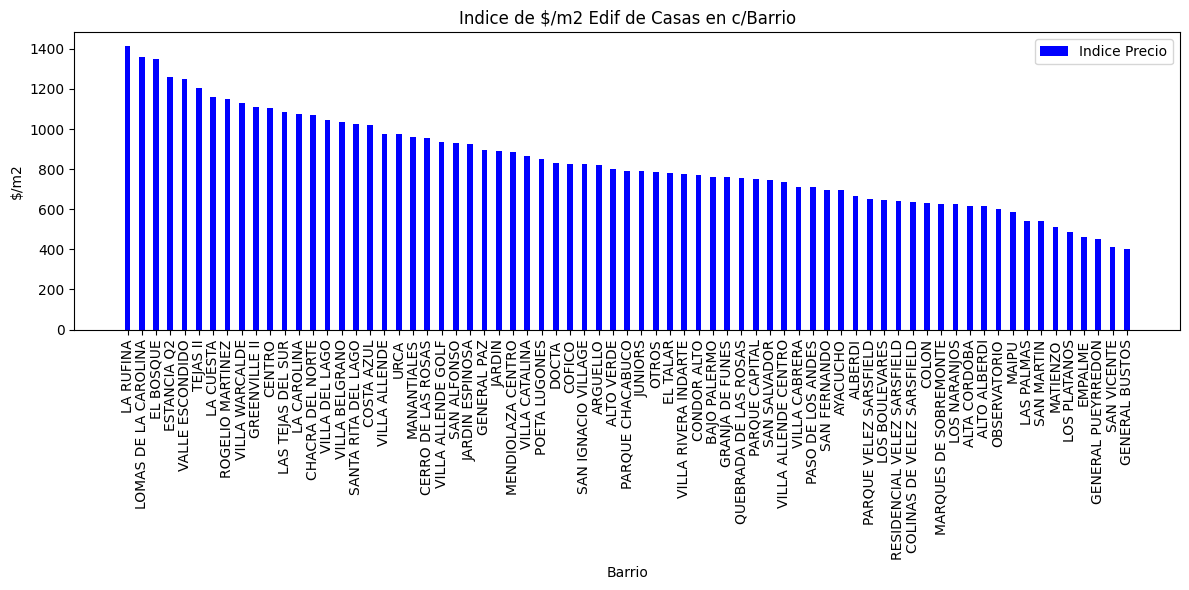

In [4]:
# ANALISIS CASAS
casas['$/m2_total'] = casas['precioUSD'] / casas['terrenoTotal']
casas['$/m2_edif'] = casas['precioUSD'] / casas['terrenoEdificado']

barrios = casas.groupby(['ciudad', 'barrio'])

precio_m2_total_prom = barrios['$/m2_total'].mean()
precio_m2_total_med = barrios['$/m2_total'].median()
precio_m2_edif_prom = barrios['$/m2_edif'].mean()
precio_m2_edif_med = barrios['$/m2_edif'].median()
cantidad = barrios.size()

# Create a new DataFrame to store the calculated data
resultados = pd.DataFrame({
    'Precio_m2_total_promedio': precio_m2_total_prom,
    'Precio_m2_total_mediana': precio_m2_total_med,
    'Precio_m2_edif_promedio': precio_m2_edif_prom,
    'Precio_m2_edif_mediana': precio_m2_edif_med,
    'Cantidad': cantidad
})
resultados.reset_index(inplace=True)


import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
resultados['indice'] = (resultados['Precio_m2_edif_promedio'] + resultados['Precio_m2_edif_promedio'])/2
resultados.sort_values("indice", ascending=False, inplace=True)
resultados = resultados[(resultados["Cantidad"] > 20)]
plt.figure(figsize=(12, 6))
barrio_names = resultados['barrio']
print(len(barrio_names))
bar_width = 0.4

"""
# Plot the bar for average house cost
plt.bar(barrio_names, resultados['Precio_m2_edif_promedio'], width=bar_width, label='Promedio $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, resultados['Precio_m2_edif_mediana'], width=bar_width, label='Mediana $/m2 Edif', color='orange', align='edge')
"""

plt.bar(barrio_names, resultados['indice'], width=bar_width, label='Indice Precio', color='blue')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Indice de $/m2 Edif de Casas en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()


28


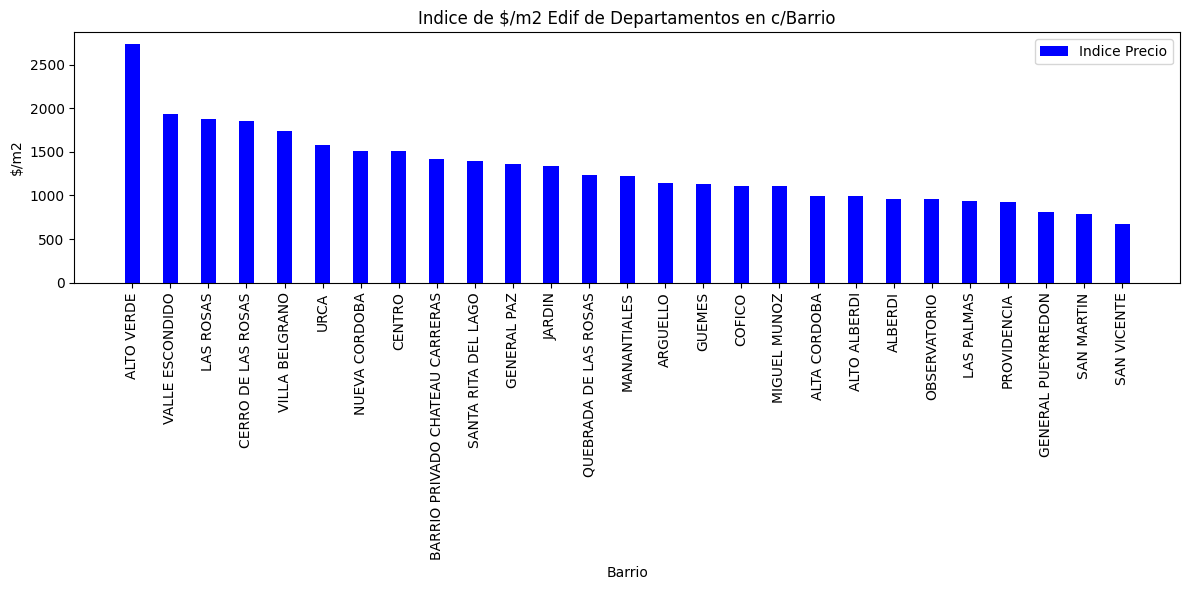

In [5]:
# ANALISIS DEPARTAMENTOS
deptos['$/m2_total'] = deptos['precioUSD'] / deptos['terrenoTotal']
deptos['$/m2_edif'] = deptos['precioUSD'] / deptos['terrenoEdificado']

barrios = deptos.groupby(['ciudad', 'barrio'])

precio_m2_total_prom = barrios['$/m2_total'].mean()
precio_m2_total_med = barrios['$/m2_total'].median()
precio_m2_edif_prom = barrios['$/m2_edif'].mean()
precio_m2_edif_med = barrios['$/m2_edif'].median()
cantidad = barrios.size()

# Create a new DataFrame to store the calculated data
resultados = pd.DataFrame({
    'Precio_m2_total_promedio': precio_m2_total_prom,
    'Precio_m2_total_mediana': precio_m2_total_med,
    'Precio_m2_edif_promedio': precio_m2_edif_prom,
    'Precio_m2_edif_mediana': precio_m2_edif_med,
    'Cantidad': cantidad
})
resultados.reset_index(inplace=True)


import matplotlib.pyplot as plt

# Filter the DataFrame to include only rows with 'tipoPropiedad' equal to 'DEPARTAMENTO'
resultados['indice'] = (resultados['Precio_m2_edif_promedio'] + resultados['Precio_m2_edif_promedio'])/2
resultados.sort_values("indice", ascending=False, inplace=True)
resultados = resultados[(resultados["Cantidad"] > 20)]
plt.figure(figsize=(12, 6))
barrio_names = resultados['barrio']
print(len(barrio_names))
bar_width = 0.4

"""
# Plot the bar for average house cost
plt.bar(barrio_names, resultados['Precio_m2_edif_promedio'], width=bar_width, label='Promedio $/m2 Edif', color='blue')

# Plot the bar for median house cost (shifted horizontally by bar_width)
plt.bar(barrio_names, resultados['Precio_m2_edif_mediana'], width=bar_width, label='Mediana $/m2 Edif', color='orange', align='edge')
"""

plt.bar(barrio_names, resultados['indice'], width=bar_width, label='Indice Precio', color='blue')

plt.xticks(rotation=90)
plt.xlabel('Barrio')
plt.ylabel('$/m2')
plt.title('Indice de $/m2 Edif de Departamentos en c/Barrio')
plt.legend()
plt.tight_layout()
plt.show()
